In [18]:
import pyfolio as pf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from datetime import date
import ast  # Import the Abstract Syntax Trees module

In [19]:
RETRAIN_DATES = [date(2021, 12, 15), date(2022, 12, 15)]

def add_retrain_dates(plt):
    for retrain_date in RETRAIN_DATES:
        plt.axvline(x=retrain_date, color='red', linestyle='--', lw=2)

    # Dynamically adjust the vertical position for annotations to avoid intersection
    # You can adjust 'adjustment_factor' to place the text appropriately
    adjustment_factor = plt.ylim()[1] * 0.99  # Adjust this factor as needed

    # Annotate the red lines, adjusting the y position
    for retrain_date in RETRAIN_DATES:
        plt.text(retrain_date, adjustment_factor, 'Model is retrained', color='red', ha='right', va='top', rotation=45)

In [108]:
# 1overN - 0.34, SPY 0.56 (anual v. 17)

In [20]:
LINEAR_OSHARPE = 'linear_osharpe'
SPY = 'SPY'

In [21]:
perf = pd.read_csv(fr'.\perfs\{LINEAR_OSHARPE}_perf.csv', index_col=0)
benchmark =  pd.read_csv(fr'.\perfs\{SPY}_perf.csv', index_col=0)

In [22]:
strategy_returns = perf['returns']
strategy_returns.index = pd.to_datetime(strategy_returns.index)

benchmark_returns = benchmark['returns']
benchmark_returns.index = pd.to_datetime(strategy_returns.index)

In [23]:
# Zipline is using parametrc for of ~ 97.5% VaR
returns = perf['returns']

# Set the confidence level
confidence_level = 0.975

# Calculate the VaR threshold
VaR_threshold = returns.quantile(1 - confidence_level)

# Calculate Expected Shortfall as the mean of the returns that are worse than the VaR threshold
ES = returns[returns <= VaR_threshold].mean()
ES

-0.026391274514493027

Start date,2020-12-15
End date,2023-12-15
Total months,36
,Backtest
Annual return,4.816%
Cumulative returns,15.198%
Annual volatility,14.752%
Sharpe ratio,0.39
Calmar ratio,0.18
Stability,0.11
Max drawdown,-27.361%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,27.36,2021-10-20,2022-09-29,NaT,NaN
1,3.73,2021-05-07,2021-05-12,2021-09-09,90
2,2.83,2021-02-12,2021-02-26,2021-03-04,15
3,2.21,2021-03-17,2021-03-24,2021-04-01,12
4,2.09,2021-09-23,2021-09-30,2021-10-14,16


C:\Users\seidm\miniconda3\envs\ml4t\lib\site-packages\pandas\core\indexes\base.py:5278: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


Stress Events,mean,min,max
New Normal,0.02%,-4.67%,4.16%


C:\Users\seidm\miniconda3\envs\ml4t\lib\site-packages\pandas\core\indexes\base.py:5278: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


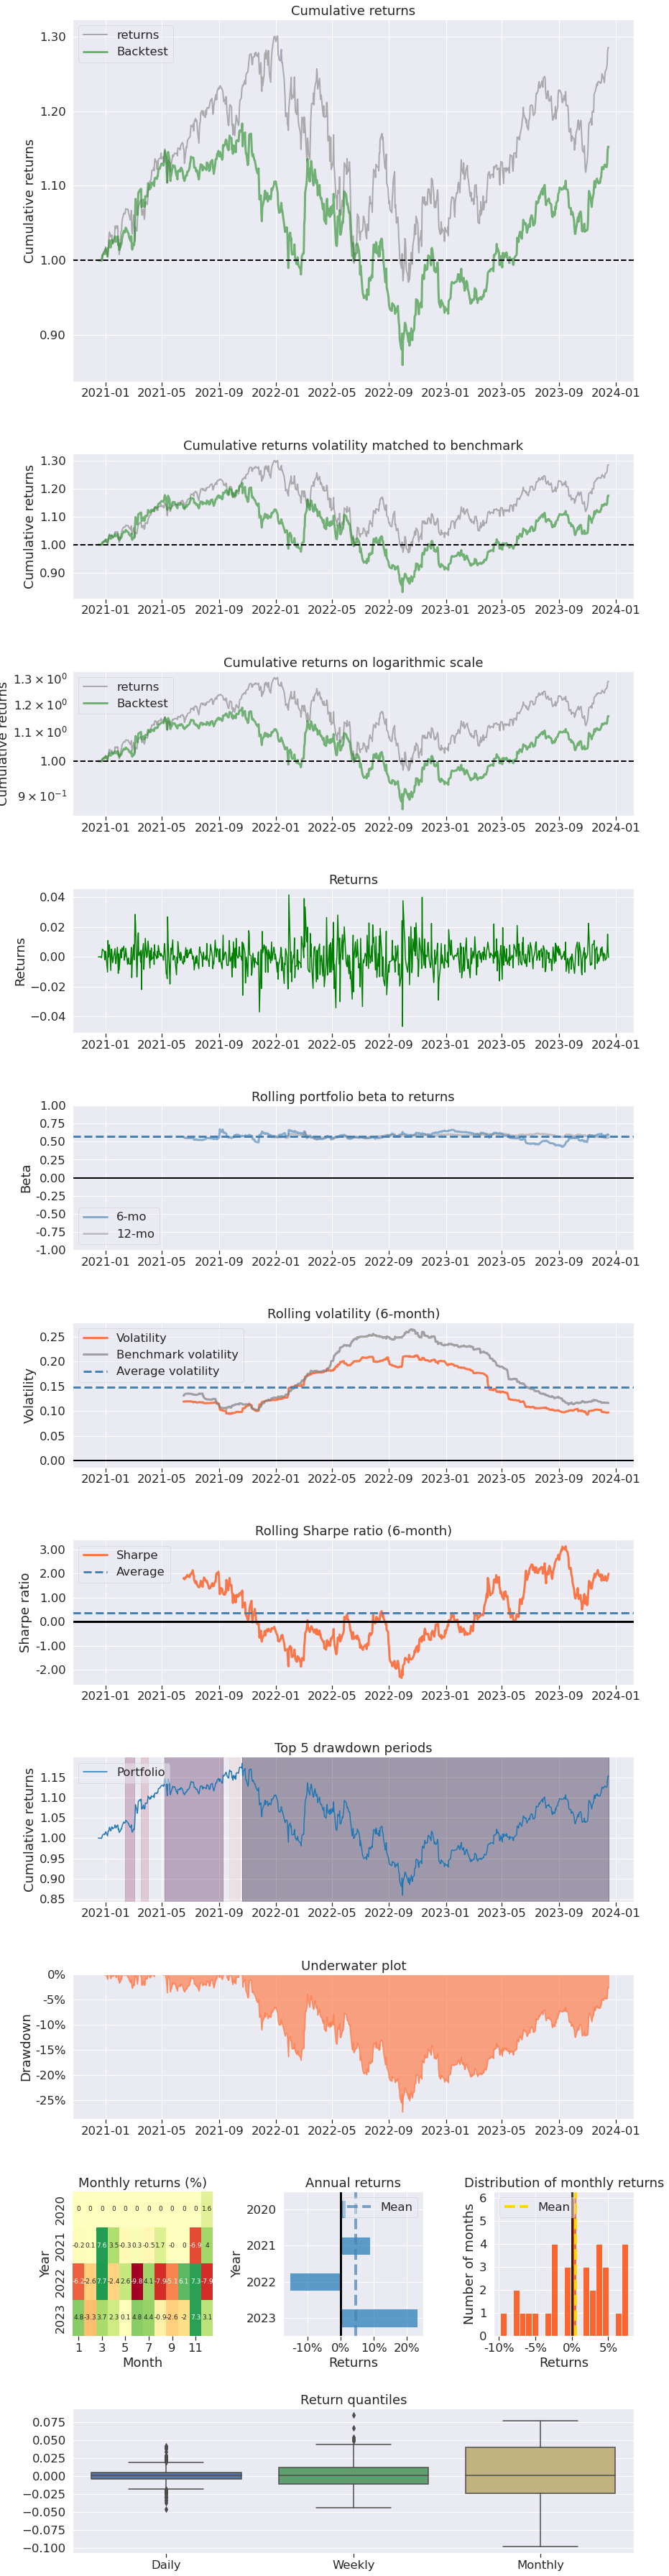

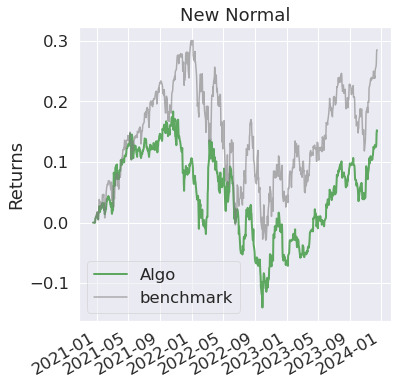

In [24]:
pf.create_full_tear_sheet(strategy_returns, benchmark_rets=benchmark_returns)

# Sharpe Ratio

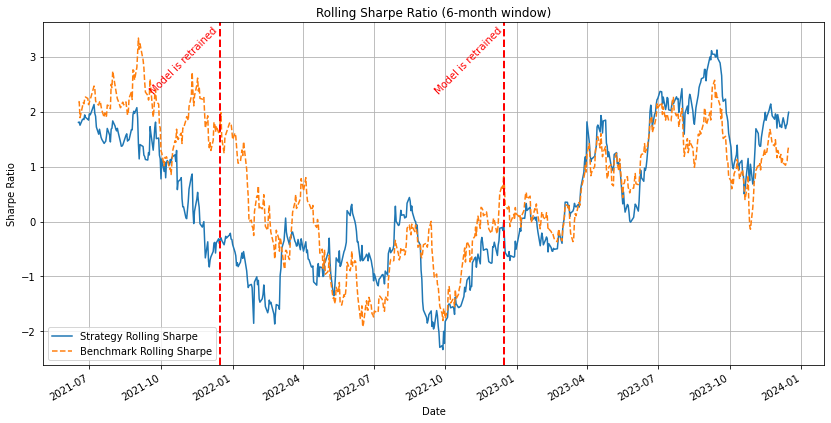

In [27]:
risk_free_rate = 0.0  # Adjust as necessary
window = 126  # 6 months rolling window for daily returns

# Calculate daily excess returns for both strategy and benchmark
excess_returns_strategy = strategy_returns - risk_free_rate
excess_returns_benchmark = benchmark_returns - risk_free_rate

# Calculate rolling Sharpe ratios
rolling_sharpe_strategy = (excess_returns_strategy.rolling(window=window).mean() / 
                           excess_returns_strategy.rolling(window=window).std()) * np.sqrt(252)

rolling_sharpe_benchmark = (excess_returns_benchmark.rolling(window=window).mean() / 
                            excess_returns_benchmark.rolling(window=window).std()) * np.sqrt(252)





# Plot the rolling Sharpe ratios
plt.figure(figsize=(14, 7))
rolling_sharpe_strategy.plot(label='Strategy Rolling Sharpe', legend=True)
rolling_sharpe_benchmark.plot(label='Benchmark Rolling Sharpe', legend=True, linestyle='--')
plt.title('Rolling Sharpe Ratio (6-month window)')
plt.ylabel('Sharpe Ratio')
plt.xlabel('Date')
plt.grid(True)

add_retrain_dates(plt)

plt.show()

# Cumultive Returns 

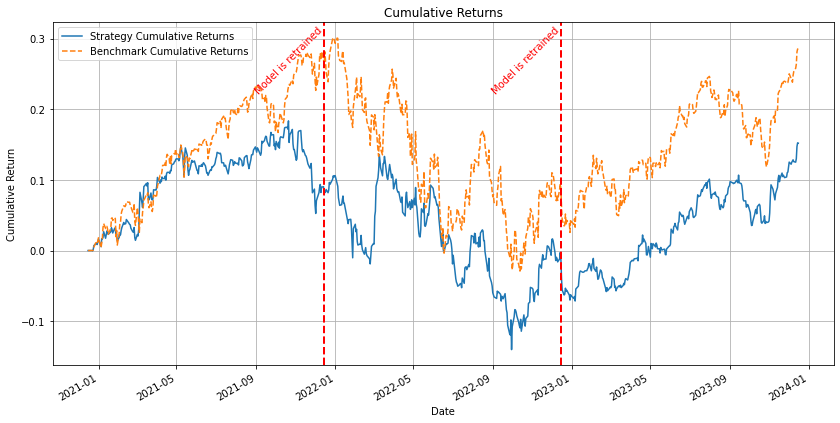

In [26]:
cumulative_returns_strategy = (1 + strategy_returns).cumprod() - 1
cumulative_returns_benchmark = (1 + benchmark_returns).cumprod() - 1

# Plot the cumulative returns
plt.figure(figsize=(14, 7))
cumulative_returns_strategy.plot(label='Strategy Cumulative Returns', legend=True)
cumulative_returns_benchmark.plot(label='Benchmark Cumulative Returns', legend=True, linestyle='--')


add_retrain_dates(plt)

plt.title('Cumulative Returns')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.grid(True)
plt.legend()
plt.show()

# Rolling volatility

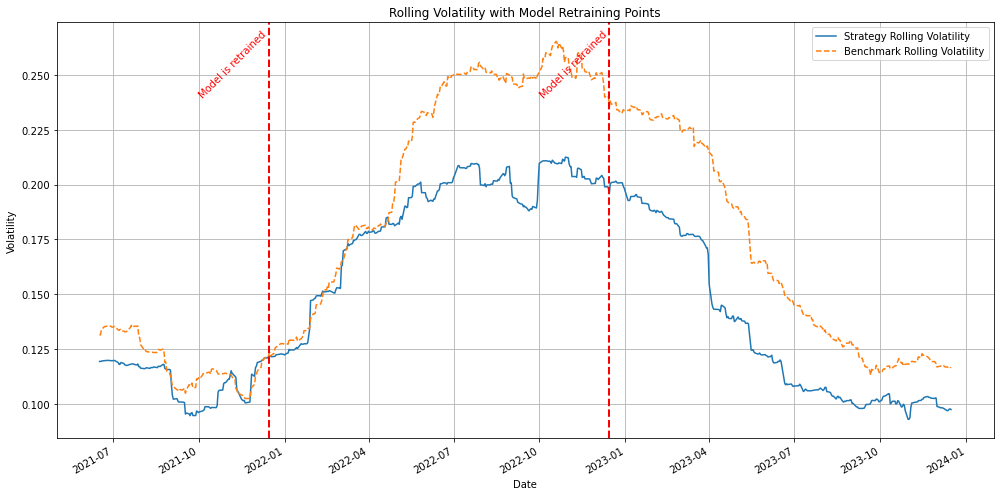

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date

# Assuming 'strategy_returns' and 'benchmark_returns' are Pandas Series
# of your strategy's and benchmark's daily returns, respectively
window = 126  # Define the rolling window (e.g., 126 trading days for a 6-month window)

# Calculate rolling volatility for both strategy and benchmark
rolling_volatility_strategy = strategy_returns.rolling(window=window).std() * np.sqrt(252)  # Annualize the volatility
rolling_volatility_benchmark = benchmark_returns.rolling(window=window).std() * np.sqrt(252)  # Annualize the volatility

# Plot the rolling volatilities
plt.figure(figsize=(14, 7))
rolling_volatility_strategy.plot(label='Strategy Rolling Volatility', legend=True)
rolling_volatility_benchmark.plot(label='Benchmark Rolling Volatility', legend=True, linestyle='--')


plt.title('Rolling Volatility with Model Retraining Points')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.grid(True)
plt.legend()
plt.tight_layout()  # Adjust layout to make room for the legend and annotations
add_retrain_dates(plt)
plt.show()


# Rolling beta

C:\Users\seidm\AppData\Local\Temp\tmpj99241ra\ipykernel_4492\3946155852.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  rolling_beta = pd.Series(index=strategy_returns.index)


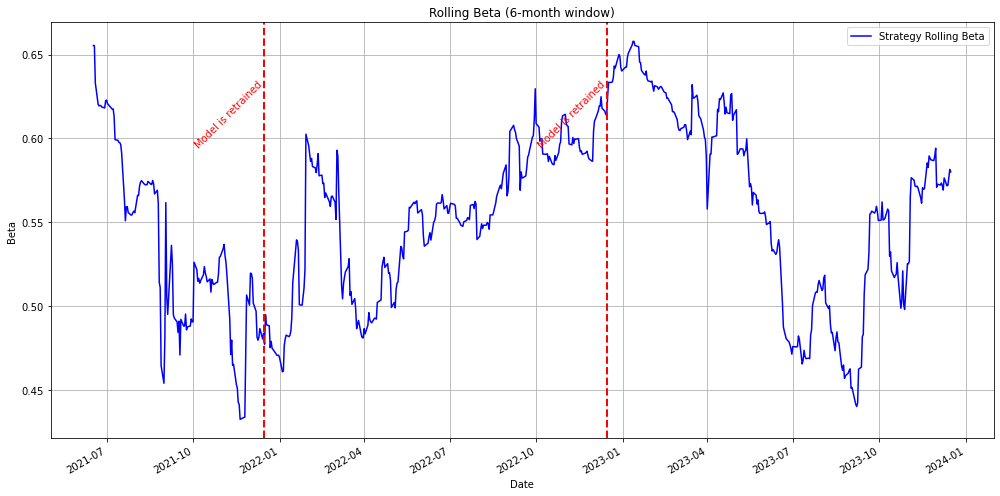

In [116]:
window = 126  # 6 months rolling window

# Prepare the benchmark returns with an intercept for OLS regression
benchmark_returns_with_const = sm.add_constant(benchmark_returns)

# Initialize an empty DataFrame to store the rolling beta
rolling_beta = pd.Series(index=strategy_returns.index)

# Perform the rolling regression
for end in range(window, len(strategy_returns) + 1):
    start = end - window
    y = strategy_returns[start:end]
    X = benchmark_returns_with_const[start:end]
    model = sm.OLS(y, X).fit()
    rolling_beta[end-1] = model.params[1]  # params[0] is the intercept, params[1] is the beta

# Plot the rolling beta
plt.figure(figsize=(14, 7))
rolling_beta.plot(label='Strategy Rolling Beta', color='blue')
plt.title('Rolling Beta (6-month window)')
plt.ylabel('Beta')
plt.xlabel('Date')
plt.grid(True)

# Add vertical red lines for model retraining dates
retrain_dates = [date(2021, 12, 15), date(2022, 12, 15)]
for retrain_date in retrain_dates:
    plt.axvline(x=retrain_date, color='red', linestyle='--', lw=2)

# Dynamically adjust the vertical position for annotations to avoid intersection
adjustment_factor = plt.ylim()[1] * 0.95  # Adjust this factor as needed

# Annotate the red lines, adjusting the y position
for retrain_date in retrain_dates:
    plt.text(retrain_date, adjustment_factor, 'Model is retrained', color='red', ha='right', va='top', rotation=45)

plt.legend()
plt.tight_layout()
plt.show()

C:\Users\seidm\AppData\Local\Temp\tmpj99241ra\ipykernel_4492\2104972555.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  rolling_beta = pd.Series(index=strategy_returns.index)


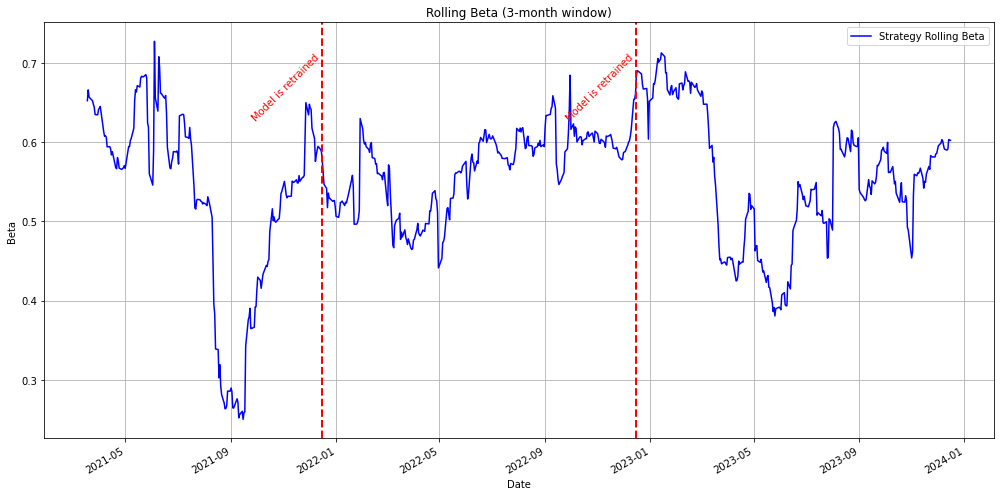

In [117]:
window = 63  # 3 months rolling window

# Prepare the benchmark returns with an intercept for OLS regression
benchmark_returns_with_const = sm.add_constant(benchmark_returns)

# Initialize an empty DataFrame to store the rolling beta
rolling_beta = pd.Series(index=strategy_returns.index)

# Perform the rolling regression
for end in range(window, len(strategy_returns) + 1):
    start = end - window
    y = strategy_returns[start:end]
    X = benchmark_returns_with_const[start:end]
    model = sm.OLS(y, X).fit()
    rolling_beta[end-1] = model.params[1]  # params[0] is the intercept, params[1] is the beta

# Plot the rolling beta
plt.figure(figsize=(14, 7))
rolling_beta.plot(label='Strategy Rolling Beta', color='blue')
plt.title('Rolling Beta (3-month window)')
plt.ylabel('Beta')
plt.xlabel('Date')
plt.grid(True)

# Add vertical red lines for model retraining dates
retrain_dates = [date(2021, 12, 15), date(2022, 12, 15)]
for retrain_date in retrain_dates:
    plt.axvline(x=retrain_date, color='red', linestyle='--', lw=2)

# Dynamically adjust the vertical position for annotations to avoid intersection
adjustment_factor = plt.ylim()[1] * 0.95  # Adjust this factor as needed

# Annotate the red lines, adjusting the y position
for retrain_date in retrain_dates:
    plt.text(retrain_date, adjustment_factor, 'Model is retrained', color='red', ha='right', va='top', rotation=45)

plt.legend()
plt.tight_layout()
plt.show()

# Distance between porfolio weights

In [118]:
perf['weights']

2020-12-15 21:00:00+00:00                                                  NaN
2020-12-16 21:00:00+00:00                                                  NaN
2020-12-17 21:00:00+00:00                                                  NaN
2020-12-18 21:00:00+00:00                                                  NaN
2020-12-21 21:00:00+00:00    [-0.07595507055521011, 0.2366558462381363, -0....
                                                   ...                        
2023-12-11 21:00:00+00:00    [0.06416240334510803, 0.2581533193588257, -0.0...
2023-12-12 21:00:00+00:00    [0.06416240334510803, 0.2581533193588257, -0.0...
2023-12-13 21:00:00+00:00    [0.06416240334510803, 0.2581533193588257, -0.0...
2023-12-14 21:00:00+00:00    [0.06416240334510803, 0.2581533193588257, -0.0...
2023-12-15 21:00:00+00:00    [0.06416240334510803, 0.2581533193588257, -0.0...
Name: weights, Length: 758, dtype: object

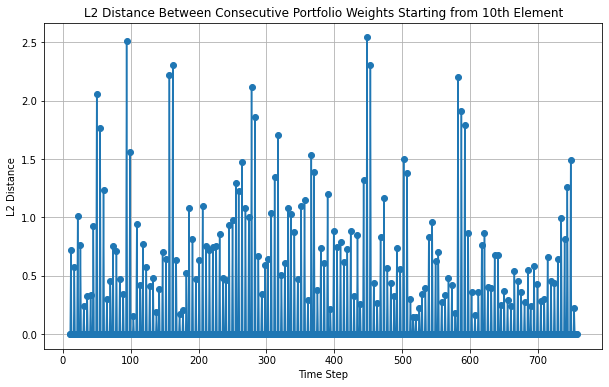

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Example 'perf' DataFrame setup for demonstration; replace with your actual data
# perf = pd.DataFrame({
#     'weights': [
#         np.array([0.1, 0.9]),
#         np.array([0.2, 0.8]),
#         np.array([0.25, 0.75]),
#         # Your actual weight arrays
#     ]
# })

# Function to calculate L2 distance between two arrays
def calculate_l2_distance(arr1, arr2):
    return np.sqrt(np.sum((arr1 - arr2) ** 2))

# Start from the 10th element (index 9 since indexing starts at 0)
start_index = 9

# Calculate L2 distances starting from the 10th element
l2_distances = np.array([
    calculate_l2_distance(
    np.array(ast.literal_eval(perf['weights'][i])), 
    np.array(ast.literal_eval(perf['weights'][i+1]))
)
    for i in range(start_index, len(perf['weights']) - 1)
])

#l2_distances = l2_distances[l2_distances != 0]

# Plotting the L2 distances
plt.figure(figsize=(10, 6))
plt.plot(range(start_index + 1, start_index + len(l2_distances) + 1), l2_distances, marker='o', linestyle='-')
plt.title('L2 Distance Between Consecutive Portfolio Weights Starting from 10th Element')
plt.xlabel('Time Step')
plt.ylabel('L2 Distance')
plt.grid(True)
plt.show()


In [120]:
l2_distances.mean()

0.1597855273879831

# 